In [1]:
import torch
from torch import nn
from torch import autograd
import numpy as np
import pylab as pl

from torchvision import transforms as T

In [2]:
torch.cuda.cudnn_benchmark = True
torch.backends.cudnn.enabled = True
torch.set_grad_enabled(False)
torch.inference_mode(True)

torch.is_inference_mode_enabled(), torch.is_grad_enabled()

(False, False)

In [ ]:
class point:
    """A 2D point class object
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def L2_norm(self):
        return self.x**2 + self.y**2

size: 16, iters: 1000, loss: 0.0
size: 32, iters: 1500, loss: 1.2257689065424838e-16
size: 64, iters: 3500, loss: 5.061401436483933e-16
size: 128, iters: 5000, loss: 1.301413925050858e-15
size: 128, iters: 5500, loss: 9.545268280959098e-16
size: 256, iters: 5000, loss: 3.927387691590126e-15
size: 256, iters: 8500, loss: 8.234225920638564e-16
size: 512, iters: 5000, loss: 2.5928210028628535e-15
size: 512, iters: 10000, loss: 1.426226559169384e-15
size: 512, iters: 12500, loss: 9.709458206246056e-16
size: 1024, iters: 5000, loss: 1.0091694529188767e-15
size: 1024, iters: 5500, loss: 9.097123265599345e-16
size: 2048, iters: 2000, loss: 9.609777251430801e-16
size: 4096, iters: 500, loss: 9.345075220249096e-16
size: 8192, iters: 500, loss: 4.392957180526525e-16


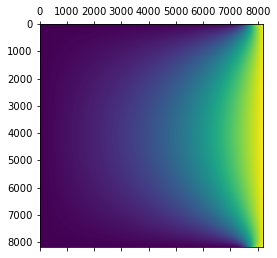

size: 256, iters: 5000, loss: 3.1073799089398335e-10
size: 256, iters: 10000, loss: 7.479331043391824e-11
size: 256, iters: 15000, loss: 2.769963945714604e-11
size: 256, iters: 20000, loss: 1.1934935678636904e-11
size: 256, iters: 25000, loss: 5.434039503093846e-12
size: 256, iters: 30000, loss: 2.5216580126080634e-12
size: 256, iters: 35000, loss: 1.1776934679200157e-12
size: 256, iters: 40000, loss: 5.514793808246432e-13
size: 256, iters: 45000, loss: 2.5863393458142037e-13
size: 256, iters: 50000, loss: 1.214550785248389e-13


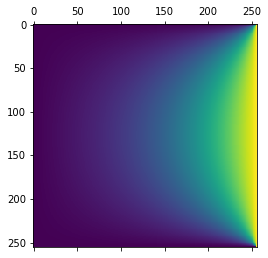

(tensor(4.3930e-16), tensor(1.2146e-13, device='cuda:0'))

In [7]:
class Solution2DPoisson:
    def __init__(self, N, device=None, boundary_conditions=None,
                 loss=nn.MSELoss()):
        self.N = N

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)

        if boundary_conditions is not None:
            self.set_boundary_conditions = boundary_conditions

        self.loss = loss

        self.sol = torch.zeros((1, 1, N, N), device=self.device)

        filter = torch.diag(torch.ones(2, device=self.device), 1)*0.25
        filter = filter + filter.T
        filter = filter.view(1, 1, *filter.size())
        self.filter = filter

    @staticmethod
    @torch.jit.script
    def set_boundary_conditions(x):
        x[:, :, :, -1] = 1

        return x

    def compute_loss(self):
        return self.loss(self.sol[:, :, 1:-1, 1:-1],
                         nn.functional.conv2d(self.sol, self.filter))

    def solve(self, steps):
        self.set_boundary_conditions(self.sol)

        l = 1.
        for i in range(1, steps+1):
            self.sol[:, :, 1:-1, 1:-1] = nn.functional.conv2d(self.sol, self.filter)

            if i % (steps//100) == 0:
                l = self.compute_loss()
                self.iters = i
                if l < 1e-15:
                    print(self)
                    break

            if i % (steps//10) == 0:
                print(self)

        return self.compute_loss()

    def resize(self, N):
        self.sol = T.Resize((N, N), T.InterpolationMode.BILINEAR)(self.sol)
        self.N = N

    def show(self):
        pl.matshow(self.sol.cpu().squeeze())
        pl.show()

    def __repr__(self):
        return f"size: {self.N}, iters: {self.iters}, loss: {self.compute_loss().item()}"


ns = np.logspace(4, 13, 10, base=2).astype(int)
solution = Solution2DPoisson(ns[0], device="cpu")

for n in ns:
    solution.resize(n)
    loss = solution.solve(50000)

solution.show()


solution2 = Solution2DPoisson(256)

loss2 = solution2.solve(50000)

solution2.show()

loss, loss2


In [100]:
def cost_slices(p, r):
    return 1/p + 2*r

def cost_cubes(p, r):
    return (1/p**(1/3) + 2*r)**3

def cost(p, r):
    return cost_slices(p, r) / (cost_cubes(p, r) + cost_slices(p, r))

p = np.arange(1, 256)
r = np.logspace(-3, np.log10(0.3), 255)

pp, rr = np.meshgrid(p, r)

Z = cost(pp, rr)

%matplotlib qt

pl.contourf(pp, rr, Z, 128)
pl.xscale("log")
pl.yscale("log")
pl.colorbar()
pl.show()

In [103]:
R = np.logspace(-5, np.log10(0.3), 1000)
pl.plot(R, cost(16, R))
pl.xscale("log")

In [2]:
# net = MLP()

def f(x):
    return net(x)

x = torch.linspace(-1, 1, 18).view(-1, 3)


# y = f(x)


def grad(x):
    v = torch.ones_like(x)
    return autograd.functional.jvp(f, x, v, create_graph=True)[1]

def hessian(x):
    v = torch.ones_like(x)
    return autograd.functional.jvp(grad, x, v)[1]

In [3]:
class Block(nn.Module):
    def __init__(self, in_features, out_features, skip=False):
        super().__init__()
        self.skip = skip

        self.block = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, out_features),
            nn.GELU(),
        )
    def forward(self, x):
        if self.skip:
            return x + self.block(x)
        
        return self.block(x)


class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            Block(3, 128),
            Block(128, 128, skip=True),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return torch.view_as_complex(self.layers(x))


In [4]:
def hydrogen_potential(x):
    return -1/x.norm(dim=1)


class Hamiltonian():
    def __init__(self, net, potential):
        self.net = net
        self.potential = potential

    def grad(self, x):
        v = torch.ones_like(x)
        f, grad = autograd.functional.jvp(self.net, x, v, create_graph=True)

        self.f = f

        return grad

    def grad_and_hessian(self, x):
        v = torch.ones_like(x)
        grad, hessian = autograd.functional.jvp(self.grad, x, v, create_graph=True)
        
        return grad, hessian

    def kinetic_functional(self, x):
        _, k = self.grad_and_hessian(x)
        return -k

    def __call__(self, x):
        k = self.kinetic_functional(x)
        v = self.potential(x) * self.f

        return k + v, self.f


class QuantumLoss:
    def __init__(self, hamiltonian, total_volume):
        self.hamiltonian = hamiltonian
        self.total_volume = total_volume

    def dot(self, x, y):
        return (x.conj() * y).sum() * self.total_volume / x.size()[0]

    def __call__(self, x):
        h, f = hamiltonian(x)
        
        norm = self.dot(f, f).abs()
        
        # Maybe divide f by its norm?
        h, f = h / norm, f / norm
        
        E = self.dot(h, f)
        # E = self.dot(h, f) / norm

        MSE = (h - E*f).abs().mean()
        
        return MSE, E, norm


In [38]:
model = lambda x: torch.exp(-2*x.norm(dim=1))

hamiltonian = Hamiltonian(model, hydrogen_potential)
criterion = QuantumLoss(hamiltonian, 10**3)

In [39]:
# net.eval()

points = torch.logspace(2, 6, 100).int()
MSEs, Es, norms = [], [], []
for point in points:
    with torch.no_grad():
        x = torch.rand((point, 3)) * 10 - 5
        MSE, E, norm = criterion(x)
        MSEs.append(MSE)
        Es.append(E)
        norms.append(norm)

In [47]:
Es[-6]

tensor(5.2833)

In [5]:
net = MLP().cpu()
net.train()

model = lambda x: net(x)*torch.exp(-x.norm(dim=1))

hamiltonian = Hamiltonian(model, hydrogen_potential)
criterion = QuantumLoss(hamiltonian, 10**3)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)

losses = []
for i in range(500):
    x = torch.rand((256, 3)) * 10 - 5
    optimizer.zero_grad()

    MSE, E, norm = criterion(x)
    loss = E.real + 100*MSE

    loss.backward()

    optimizer.step()
    scheduler.step()
    losses.append(loss.detach().cpu().item())
    
    print(MSE, E, norm)

tensor(0.7320, grad_fn=<MeanBackward0>) tensor(-10.4518+0.2970j, grad_fn=<DivBackward0>) tensor(0.0791, grad_fn=<AbsBackward>)
tensor(0.2841, grad_fn=<MeanBackward0>) tensor(-5.7859+0.1396j, grad_fn=<DivBackward0>) tensor(0.1303, grad_fn=<AbsBackward>)
tensor(0.0261, grad_fn=<MeanBackward0>) tensor(-0.2690+0.0307j, grad_fn=<DivBackward0>) tensor(0.5018, grad_fn=<AbsBackward>)
tensor(0.0245, grad_fn=<MeanBackward0>) tensor(-1.2778+0.0122j, grad_fn=<DivBackward0>) tensor(0.8548, grad_fn=<AbsBackward>)
tensor(0.0372, grad_fn=<MeanBackward0>) tensor(-1.4928+0.0221j, grad_fn=<DivBackward0>) tensor(0.3742, grad_fn=<AbsBackward>)
tensor(0.0261, grad_fn=<MeanBackward0>) tensor(0.5108+0.0202j, grad_fn=<DivBackward0>) tensor(0.5999, grad_fn=<AbsBackward>)
tensor(0.0154, grad_fn=<MeanBackward0>) tensor(-0.8626+0.0047j, grad_fn=<DivBackward0>) tensor(1.5565, grad_fn=<AbsBackward>)
tensor(0.0146, grad_fn=<MeanBackward0>) tensor(-0.5494+0.0056j, grad_fn=<DivBackward0>) tensor(1.3002, grad_fn=<AbsBac

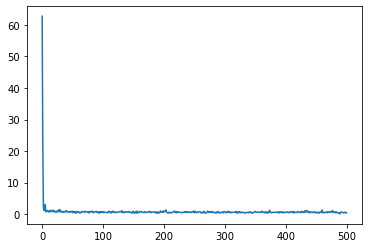

In [6]:
pl.plot(np.array(losses))

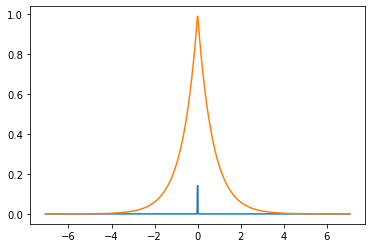

In [28]:
# net.eval()

v = torch.Tensor([1,0,1])
v = v/v.norm()
x = ((torch.linspace(-10, 10, 1024)) * v.view(-1, 1)).T

with torch.no_grad():
    y = (model(x)).abs()**2

pl.plot(x[:, 0], y.cpu())
pl.plot(x[:, 0], torch.exp(-x.norm(dim=1)))

In [29]:
# net.eval()

points = torch.logspace(2, 6, 100).int()
MSEs, Es, norms = [], [], []
for point in points:
    with torch.no_grad():
        x = torch.rand((point, 3)) * 10 - 5
        MSE, E, norm = criterion(x)
        MSEs.append(MSE)
        Es.append(E)
        norms.append(norm)

In [30]:
Es[-1]

tensor(-1.8330e+14)

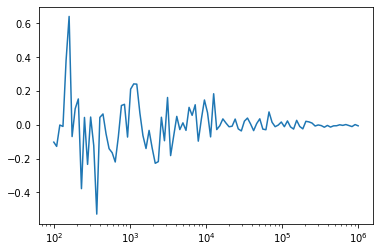

In [11]:
pl.plot(points, Es)
pl.xscale("log")

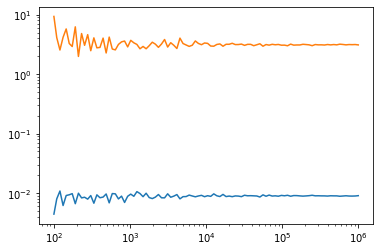

In [13]:
pl.loglog(points, MSEs)
pl.loglog(points, norms)